# <b>Data Diagnostics I </b> *✲ﾟ*｡✧٩(･ิᴗ･ิ๑)۶*✲ﾟ*｡✧

In this notebook we will explore taking the min-max or percentile normalization between datasets and also derivatives and see how our data changes, i.e. the distribution of each variable, check the principal components, etc.

In [72]:
import helper_functions as hf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pynumdiff as pdiff
import pandas as pd
import importlib
importlib.reload(hf)

imputed_dataframe = hf.wbstruct_dataframes.loading_pkl('imputed_dataframe.pkl')
dataframes = hf.wbstruct_dataframes.loading_pkl('dataframes.pkl')
turn_vec = hf.wbstruct_dataframes.loading_pkl('turn_vec.pkl')

### Up-/Downsampling
Our datasets have different sizes, so we have to upsample them. Most recordings range from 3200 to 3780 time points but there is one dataset with 4146 and one with 5450 time points. 8 datasets have exactly 3529 time points. We will therefore down- or upsample to this number via linear interpolation (computing the slope between two data points) implemented in numpy.   

In [4]:
imputed_upsampled = imputed_dataframe.copy()
resampled_dataframes = []
num_pts = 3529
indices = np.linspace(0, 1, num_pts)

start_index = 0

def interpolate(vector, indices, length):
    vector = np.interp(indices, np.linspace(0, 1, length), vector)
    return vector


for dataset in dataframes.values():

    length = len(dataset)
    end_index = start_index + length
    
    if length == num_pts:
        resampled_dataframes.append(imputed_upsampled.iloc[start_index:end_index])
    else:
        resampled_dataframes.append(imputed_upsampled.iloc[start_index:end_index].apply(
            lambda x: interpolate(x, indices, length), axis=0)) 

    start_index = end_index
    
resampled_dataframe = pd.concat(resampled_dataframes, ignore_index=True)

### Time Derivatives
Since we are interested in the shape of our data and want to eliminate noise as much as possible, we will take the time derivative of our data. 
To this end we will use a finitie difference method to compute the first order derivative of our data. Finite difference methods estimate derivatibes by looking at the changes in the values over small intervals dt. This time step size dt is the reciprocal of the sampling frequency, which is 2.9-3.5 volumes per second for Rebecca's data and about 3 volumes per second for Kerem's data.
We will apply this on each dataset individually.

In [12]:
resampled_derivatives = resampled_dataframe.copy()
dt = 1/3 # time step: 1/(frame rate)
start_index = 0
for dataset in dataframes.values():
    end_index = start_index + len(dataset)
    for col_index in range(len(resampled_derivatives.columns)):
        x_hat, dxdt_hat = pdiff.finite_difference.first_order(resampled_derivatives.iloc[start_index:end_index, col_index], dt) # x_hat: estimated (smoothed) x, dxdt_hat: estimated dx/dt
        resampled_derivatives.iloc[start_index:end_index, col_index] = dxdt_hat
    start_index = end_index
    

### Normalization between datasets

Peaks can range between 0.5568866208412626 and 3.807823370864039 across all datasets
Dips can range between -3.662144465897265 and -0.3783332997969566 across all datasets


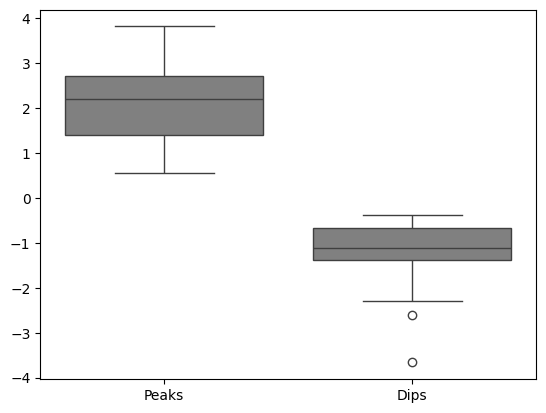

In [56]:
start_index = 0

mins = []
maxs = []

for dataset in dataframes.values():

    end_index = start_index + len(dataset)
    maxs.append(resampled_derivatives.iloc[start_index:end_index].max().max())
    mins.append(resampled_derivatives.iloc[start_index:end_index].min().min())
    start_index = end_index
    
sns.boxplot(pd.DataFrame([maxs,mins]).transpose().rename(columns={0:'Peaks',1:'Dips'}), color=".5")
print("Peaks can range between",min(maxs),"and",max(maxs),"across all datasets")
print("Dips can range between",min(mins),"and",max(mins),"across all datasets")

As seen above we have to deal with different scales across datasets so a natural next step is to normalize the data across datasets to make them comparable. We will do this by taking the min-max normalization between datasets. This means that we will take the minimum and maximum value of each variable across all datasets and then normalize each dataset to this range. This will be done the time derivatives of the resampled data.

We can also try the percentile normalization between datasets. This means that we will take the 5th and 95th percentile of each variable across all datasets and then normalize each dataset to this range. This will be done the time derivatives of the resampled data.

### MinMax

In [74]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

test_resampled = resampled_derivatives.copy()

scaler = MinMaxScaler()
minmaxed_data = pd.DataFrame(scaler.fit_transform(test_resampled), columns = test_resampled.columns)

In [75]:
minmaxed_data.head()

,URADL,URADR,URYVR,URYVL,URYDR,URYDL,OLQDL,OLQVL,URAVR,RMED,...,DB01,DA01,DVB,DVC,PDA,AS10,VB11,RIVR,RIBL,SIADR
0,0.397359,0.223013,0.377595,0.111088,0.215470,0.406862,0.230101,0.240096,0.268910,0.467933,...,0.262205,0.523850,0.502858,0.413100,0.467670,0.299579,0.597287,0.455902,0.145187,0.199165
1,0.423888,0.185602,0.375069,0.174814,0.265385,0.396260,0.269522,0.278659,0.266818,0.483506,...,0.270260,0.530557,0.513908,0.456151,0.491528,0.330261,0.592777,0.485087,0.163555,0.158680
2,0.412902,0.120160,0.201266,0.154326,0.242680,0.262946,0.212826,0.272846,0.162591,0.487045,...,0.250302,0.508258,0.505826,0.435716,0.512739,0.333026,0.578666,0.447299,0.135544,0.110365
3,0.434194,0.130218,0.172762,0.130792,0.214411,0.263511,0.190614,0.253317,0.099202,0.484642,...,0.257143,0.513600,0.496604,0.414274,0.500551,0.318492,0.579894,0.432504,0.117749,0.114654
4,0.431862,0.129431,0.303252,0.134849,0.237536,0.385883,0.306237,0.276728,0.204142,0.493079,...,0.284855,0.531882,0.508955,0.437719,0.496678,0.330758,0.601823,0.472504,0.153540,0.149089


### Based on Quantiles: RobustScaler

In [76]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()
quartile_data = pd.DataFrame(robust_scaler.fit_transform(test_resampled), columns = test_resampled.columns)

In [77]:
quartile_data.head()

,URADL,URADR,URYVR,URYVL,URYDR,URYDL,OLQDL,OLQVL,URAVR,RMED,...,DB01,DA01,DVB,DVC,PDA,AS10,VB11,RIVR,RIBL,SIADR
0,-2.609406,1.806734,2.475498,-3.426389,-1.843632,1.966521,-1.863059,-2.270365,3.097586,-2.941641,...,-1.014220,-1.208263,-2.512947,-2.418752,-1.483832,-2.934498,-0.505813,-1.265828,-1.005474,1.706638
1,-1.161071,0.323583,2.400577,0.356530,0.193943,1.663242,-0.260351,0.056443,2.985700,-1.265282,...,-0.477669,-0.774937,0.077626,-0.284654,-0.283611,-0.305033,-0.866583,0.273284,0.557104,-0.508778
2,-1.760847,-2.270856,-2.753880,-0.859703,-0.732891,-2.150467,-2.565395,-0.294300,-2.589533,-0.884347,...,-1.807150,-2.215646,-1.817179,-1.297652,0.783404,-0.068051,-1.995535,-1.719559,-1.825723,-3.152642
3,-0.598407,-1.872111,-3.599225,-2.256761,-1.886831,-2.134299,-3.468453,-1.472666,-5.980353,-1.143033,...,-1.351460,-1.870517,-3.979175,-2.360533,0.170302,-1.313668,-1.897287,-2.499765,-3.339561,-2.917924
4,-0.725725,-1.903290,0.270694,-2.015871,-0.942867,1.366393,1.232360,-0.060056,-0.366925,-0.234747,...,0.494602,-0.689321,-1.083597,-1.198363,-0.024530,-0.262420,-0.142836,-0.390303,-0.294899,-1.033584
